## Семинар 7: "Методы оптимизации"

ФИО: Шпитальник Александр Сергеевич

In [1]:
import numpy as np
import sys
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

/home/alex/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class GD:
    def __init__(self, X, df, rate):
        self.val = X
        self.df = df
        self.rate = rate
        self.X = []
        self.Y = []
        
    def step(self):
        #print self.df(self.val)
        self.val = self.val - self.rate * self.df(self.val)
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        return self.X, self.Y

In [3]:
class Momentum:
    def __init__(self, X, df, rate, gamma):
        self.val = X
        self.df = df
        self.rate = rate
        self.gamma = gamma
        self.prev = 0.0
        self.X = []
        self.Y = []
        
    def step(self):
        self.prev = self.prev * self.gamma + self.rate * self.df(self.val)
        self.val = self.val - self.prev
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        return self.X, self.Y

In [4]:
class NAG:
    def __init__(self, X, df, rate, gamma):
        self.val = np.array(X)
        self.df = df
        self.rate = rate
        self.gamma = gamma
        self.prev = 0.0
        self.X = []
        self.Y = []
        
    def step(self):
        arg = self.val - self.prev * self.gamma * np.ones(self.val.shape)
        self.prev = self.prev * self.gamma + self.rate * self.df(arg)
        self.val = self.val - self.prev
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        return self.X, self.Y

In [5]:
class Adagrad:
    def __init__(self, X, df, rate):
        self.val = np.array(X)
        self.df = df
        self.rate = rate
        self.eps = 0.000001
        self.agr = np.zeros(self.val.shape)
        self.X = []
        self.Y = []
        
    def step(self):
        grad = self.df(self.val)
        #print grad 
        self.agr += grad ** 2.0
        self.val = self.val - self.rate*(grad / (np.sqrt(self.agr) + self.eps))
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        #print self.Y
        return self.X, self.Y

In [6]:
class Adadelta:
    def __init__(self, X, df, rate, delta):
        self.val = np.array(X)
        self.df = df
        self.rate = rate
        self.delta = delta
        self.eps = 0.000001
        self.agr = np.zeros(self.val.shape)
        self.X = []
        self.Y = []
        
    def step(self):
        grad = self.df(self.val)
        #print grad 
        self.agr = self.agr * self.delta + (1 - self.delta) * (grad ** 2)
        self.val = self.val - self.rate*(grad / (np.sqrt(self.agr) + self.eps))
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        #print self.Y
        return self.X, self.Y

In [7]:
class Adam:
    def __init__(self, X, df, rate, beta1 = 0.9, beta2 = 0.999):
        self.val = np.array(X)
        self.df = df
        self.rate = rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = 0.0
        self.v = 0.0
        self.eps = 0.000001
        self.agr = np.zeros(self.val.shape)
        self.X = []
        self.Y = []
        
    def step(self):
        grad = self.df(self.val)
        self.m = self.beta1*self.m + (1 - self.beta1)*grad
        self.v = self.beta2*self.v + (1 - self.beta2)*(grad**2)
        self.val = self.val - self.rate*(self.m / (np.sqrt(self.v) + self.eps))
        self.X.append(self.val[0])
        self.Y.append(self.val[1])
    
    def get(self):
        #print self.Y
        return self.X, self.Y

In [8]:
def get_alpha(x):
    res = []
    num = 0
    step = 1.0/len(x)
    for i in x:
        num += 1
        res.append(step * num)
    return res    

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [9]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

In [10]:
gd = GD([10, 10], df, 0.1)
for i in range(10):
    gd.step()    
    
mgd = Momentum([10, 10], df, 0.1, 0.1) 
for i in range(10):
    mgd.step()  
    
ngd = NAG([10, 10], df, 0.1, 0.1) 
for i in range(10):
    ngd.step()  
    
ag = Adagrad([10, 10], df, 1) 
for i in range(100):
    ag.step()   
    
ad = Adadelta([10, 10], df, 0.3, 0.1) 
for i in range(50):
    ad.step()     
    
am = Adam([10, 10], df, 0.1)  
for i in range(20):
    am.step()    

/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


Text(0.5,1,u'Adam')

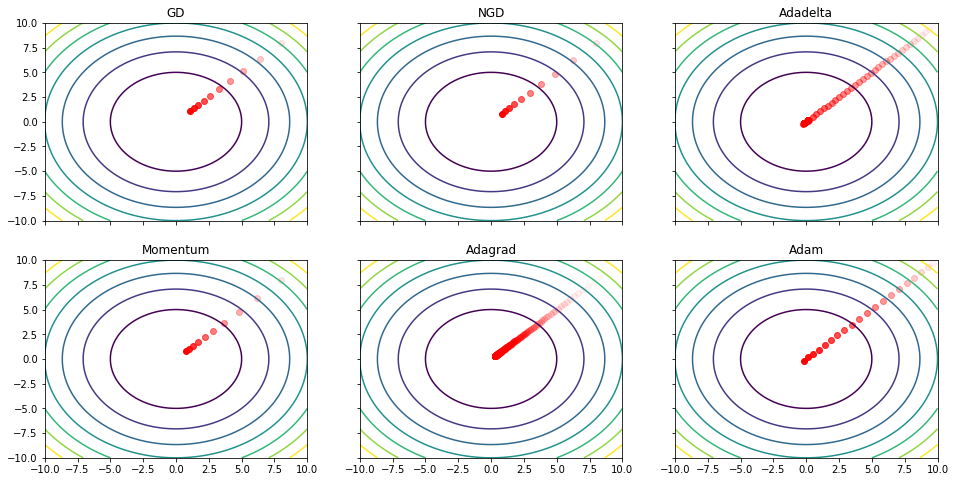

In [11]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x,y)
Z = f([X,Y]) 

fig, ax = plt.subplots(2,3, sharex = 'col', sharey = 'row', figsize = (16,8))

ax[0,0].contour(X,Y,Z, color = 'black')
x, y = gd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,0].set_title('GD')


ax[1,0].contour(X,Y,Z, color = 'black')
x, y = mgd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,0].set_title('Momentum')


ax[0,1].contour(X,Y,Z, color = 'black')
x, y = ngd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,1].set_title('NAD')


ax[1,1].contour(X,Y,Z, color = 'black')
x, y = ag.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,1].set_title('Adagrad')


ax[0,2].contour(X,Y,Z, color = 'black')
x, y = ad.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,2].set_title('Adadelta')


ax[1,2].contour(X,Y,Z, color = 'black')
x, y = am.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,2].set_title('Adam')

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [177]:
f = lambda X: (X[0]**2) * np.sin(X[0]) + (X[1]**2) * np.sin(X[1])
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + (X[0]**2)*np.cos(X[0]), 
                         2*X[1]*np.sin(X[1]) + (X[1]**2)*np.cos(X[1])])

In [190]:
gd = GD([2, 2], df, 0.4)
for i in range(50):
    gd.step()    
    
mgd = Momentum([2, 2], df, 0.2, 0.45) 
for i in range(15):
    mgd.step()  
    
ngd = NAG([2, 2], df, 0.2, 0.5) 
for i in range(20):
    ngd.step()  
    
ag = Adagrad([2, 2], df, 3) 
for i in range(20):
    ag.step()   
    
ad = Adadelta([2, 2], df, 0.3, 0.99) 
for i in range(50):
    ad.step()     
    
am = Adam([2, 2], df, 0.05)  
for i in range(30):
    am.step()    

Text(0.5,1,u'Adam')

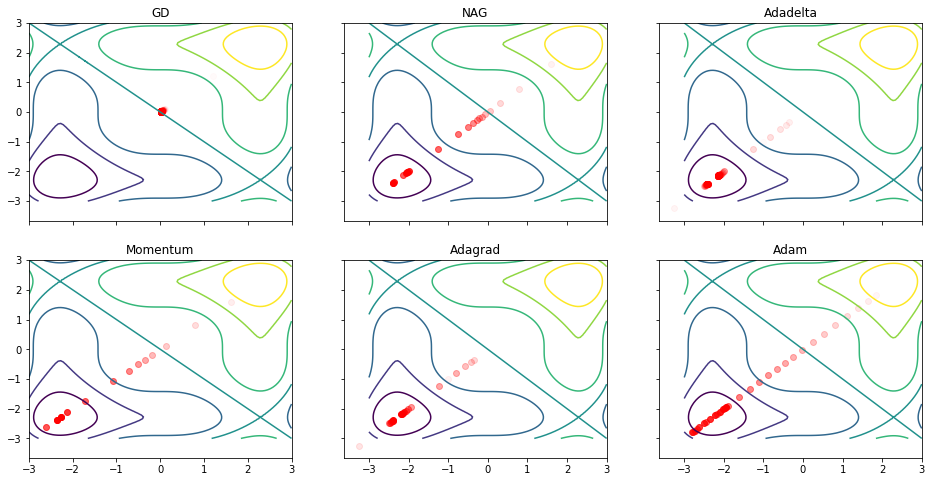

In [191]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x,y)
Z = f([X,Y]) 

fig, ax = plt.subplots(2,3, sharex = 'col', sharey = 'row', figsize = (16,8))

ax[0,0].contour(X,Y,Z)
x, y = gd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,0].set_title('GD')


ax[1,0].contour(X,Y,Z)
x, y = mgd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,0].set_title('Momentum')


ax[0,1].contour(X,Y,Z)
x, y = ngd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,1].set_title('NAG')


ax[1,1].contour(X,Y,Z)
x, y = ag.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,1].set_title('Adagrad')


ax[0,2].contour(X,Y,Z)
x, y = ad.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,2].set_title('Adadelta')


ax[1,2].contour(X,Y,Z)
x, y = am.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,2].set_title('Adam')

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [127]:
f = lambda X: (X[0]**2) * np.sin(X[0]**2) + (X[1]**2) * np.sin(X[1]**2)
df = lambda X: np.array([2*X[0]*np.sin(X[0]**2) + 2*(X[0]**3)*np.cos(X[0]**2), 
                         2*X[1]*np.sin(X[1]**2) + 2*(X[1]**3)*np.cos(X[1]**2)])

In [173]:
gd = GD([1.5, 1.5], df, 0.01)
for i in range(10):
    gd.step()    
    
mgd = Momentum([1.5, 1.5], df, 0.005, 0.3) 
for i in range(20):
    mgd.step()  
    
ngd = NAG([1.5, 1.5], df, 0.01, 0.1) 
for i in range(10):
    ngd.step()  
    
ag = Adagrad([1.5, 1.5], df, 0.1) 
for i in range(20):
    ag.step()   
    
ad = Adadelta([1.5, 1.5], df, 0.01, 0.99) 
for i in range(20):
    ad.step()     
    
am = Adam([1.5, 1.5], df, 0.1)  
for i in range(100):
    am.step()    

Text(0.5,1,u'Adam')

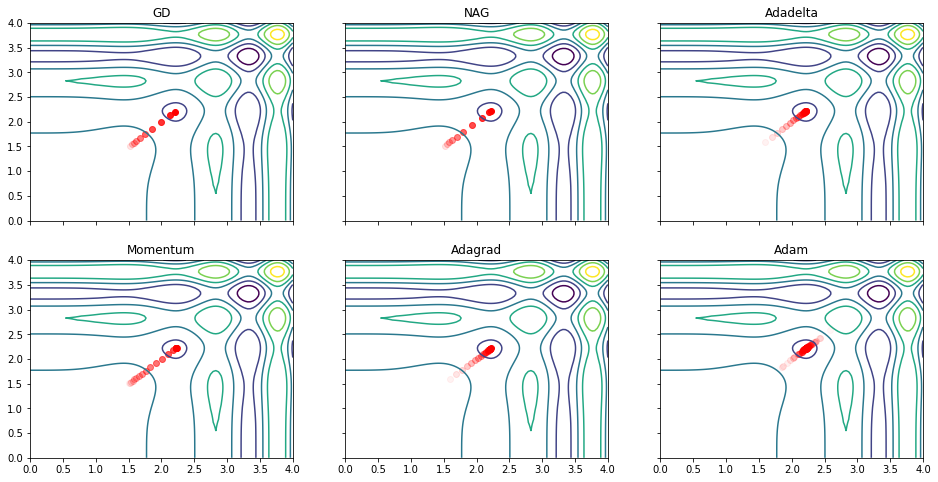

In [174]:
x = np.linspace(0, 4, 100)
y = np.linspace(0, 4, 100)

X, Y = np.meshgrid(x,y)
Z = f([X,Y]) 

fig, ax = plt.subplots(2,3, sharex = 'col', sharey = 'row', figsize = (16,8))

ax[0,0].contour(X,Y,Z)
x, y = gd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,0].set_title('GD')


ax[1,0].contour(X,Y,Z)
x, y = mgd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,0].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,0].set_title('Momentum')


ax[0,1].contour(X,Y,Z)
x, y = ngd.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,1].set_title('NAG')


ax[1,1].contour(X,Y,Z)
x, y = ag.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,1].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,1].set_title('Adagrad')


ax[0,2].contour(X,Y,Z)
x, y = ad.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[0,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[0,2].set_title('Adadelta')


ax[1,2].contour(X,Y,Z)
x, y = am.get()
a = get_alpha(x)
for i in range(len(x)):
    ax[1,2].scatter(x[i], y[i], alpha = a[i], color = 'red')
ax[1,2].set_title('Adam')

###  Часть 2: Обучение нейронной сети

In [430]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [431]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
        self.linear_layers = nn.Sequential(nn.Linear(784,100),
                                           nn.ReLU(),
                                           nn.Linear(100,100),
                                           nn.ReLU(),
                                           nn.Linear(100,10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x  
    

In [432]:
def train(network, epochs, learning_rate, opt):
    loss = nn.NLLLoss()
    optimizer = opt 
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                #X = Variable(X)
                #y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                #X = Variable(X)
                #y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [434]:
network = LinearNet()

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.163/0.315	Accuracy: 0.964/0.953

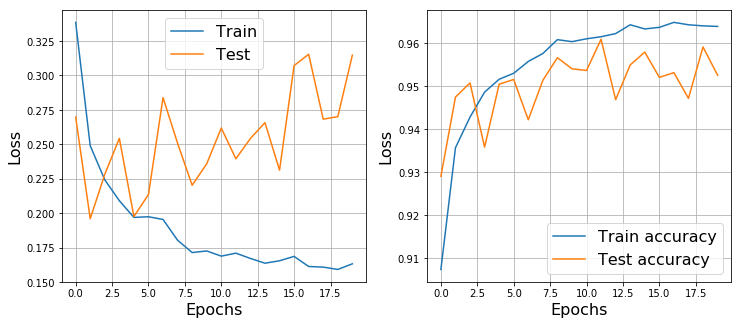

In [446]:
opt = torch.optim.Adam(network.parameters(), lr=0.01)
train(network, 20, 0.001, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.019/0.067	Accuracy: 0.996/0.979

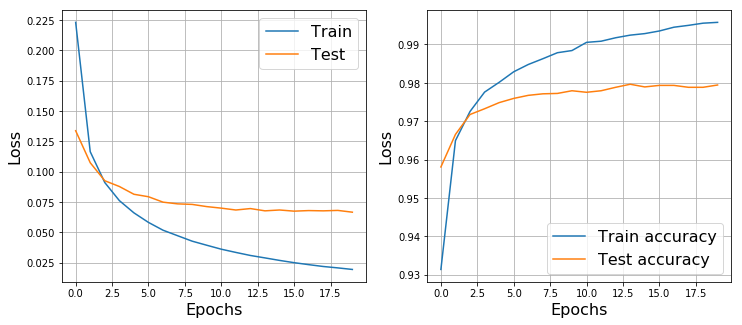

In [441]:
network = LinearNet()
opt = torch.optim.Adagrad(network.parameters(), lr=0.01)
train(network, 20, 0.01, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.141/0.146	Accuracy: 0.959/0.955

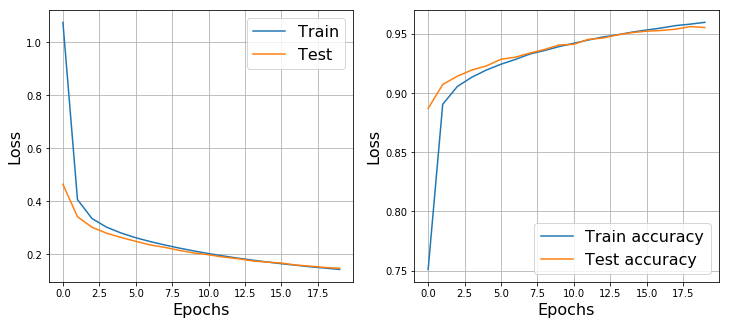

In [442]:
network = LinearNet()
opt = torch.optim.Adadelta(network.parameters(), lr=0.01)
train(network, 20, 0.01, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.026/0.072	Accuracy: 0.994/0.979

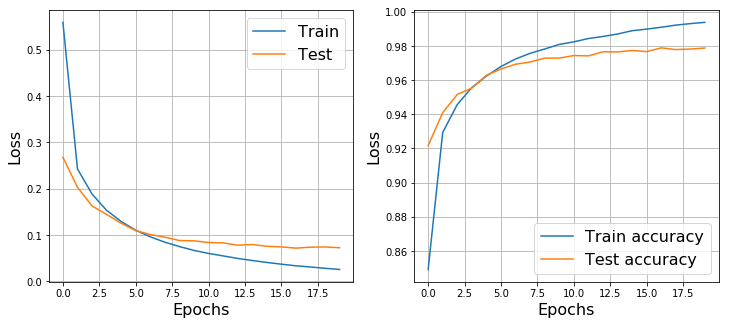

In [447]:
network = LinearNet()
opt = torch.optim.SGD(network.parameters(), lr=0.01)
train(network, 20, 0.01, opt)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [452]:
channels = 1
image_size = 28
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),                                         
                                        )
        
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9... (Train/Test) NLL: 0.072/0.140	Accuracy: 0.979/0.971

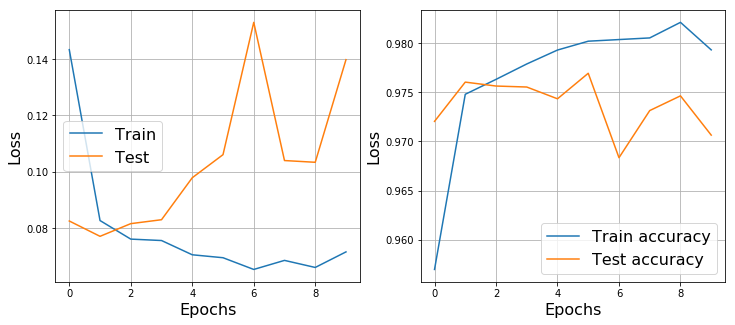

In [453]:
network = ConvNet()
opt = torch.optim.Adam(network.parameters(), lr=0.01)
train(network, 10, 0.001, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9... (Train/Test) NLL: 0.027/0.040	Accuracy: 0.992/0.987

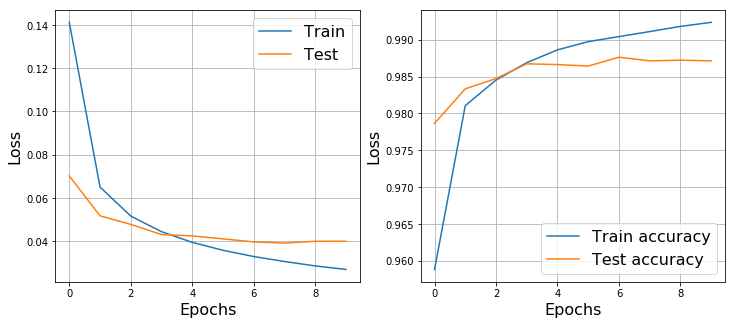

In [454]:
network = ConvNet()
opt = torch.optim.Adagrad(network.parameters(), lr=0.01)
train(network, 10, 0.01, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9... (Train/Test) NLL: 0.147/0.131	Accuracy: 0.958/0.961

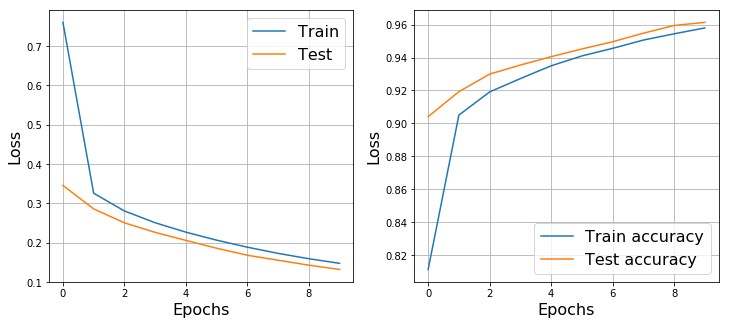

In [455]:
network = ConvNet()
opt = torch.optim.Adadelta(network.parameters(), lr=0.01)
train(network, 10, 0.01, opt)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9... (Train/Test) NLL: 0.067/0.087	Accuracy: 0.981/0.973

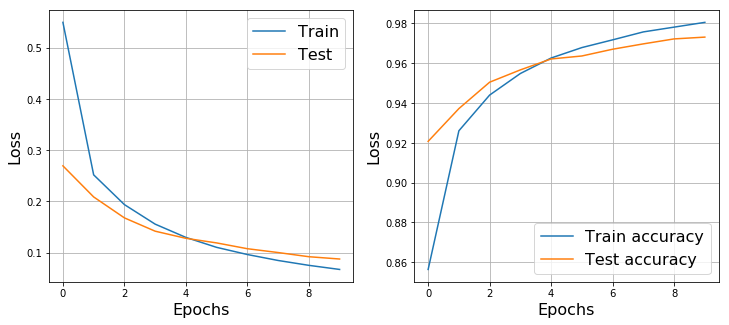

In [456]:
network = LinearNet()
opt = torch.optim.SGD(network.parameters(), lr=0.01)
train(network, 10, 0.01, opt)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: